# Multi Agent System with Langraph System with WatsonX

Hello everyone today we are going to learn how o build a Simple Multi Agent System with Langraph with WatsonX
We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

## Setup

First, install the required packages:

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain_anthropic

# Used for install IBM WatsonX
%pip install python-dotenv  ibm_watson_machine_learning
%pip install "ibm-watsonx-ai" 
%pip install "pydantic>=1.10.0" 
%pip install "langchain>=0.1.52"
%pip install "langchain_ibm>=0.1.7"


Then we setup our API keys:

In [2]:
import os
from dotenv import load_dotenv
import getpass
def _set_env(var: str):
    load_dotenv()  # Load environment variables from .env file
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

api_key = _set_env("WATSONX_API_KEY")
project_id = _set_env("PROJECT_ID")
url = "https://us-south.ml.cloud.ibm.com"


(Encouraged) [LangSmith](https://smith.langchain.com/) makes it a lot easier to see what's going on "under the hood."

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

## Part 1: Basic Chatbot with WatsonX and LangGraph
Let's create a simple chatbot using LangGraph with WatsonX. This chatbot will respond directly to user messages.

**What is LangGraph?**
LangGraph is a powerful tool that helps us build complex systems, like chatbots, by connecting different pieces of code together. Think of it like a flowchart, where each step builds on the previous one.

**Creating a StateGraph**
We'll start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". This means we can think of our chatbot as a series of states, and we'll define how it transitions between these states.

**Adding Nodes and Edges**
We'll add `nodes` to represent the different functions our chatbot can perform, like responding to user messages. We'll also add `edges` to specify how the bot should transition between these functions.

Here's the code that sets up the LangGraph State:

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


**Understanding the Code**
Let's break down what's happening in this code:

* We've defined our `State` as a special type of dictionary called a `TypedDict`. This dictionary has a single key: `messages`.
* The `messages` key is special because we're telling LangGraph how to update it. We're using a function called `add_messages` to say, "Hey, when we add new messages, append them to the existing list instead of overwriting it."
* Now our graph knows two important things:
	1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
	2. `messages` will be appended to the current list, rather than directly overwritten.

**Next Steps**
Next, we'll add a "chatbot" node. Nodes represent individual tasks or functions, and they're typically regular Python functions. We'll explore this in more detail in the next section.

**Foundation Models on WatsonX.ai**

WatsonX.ai provides a range of foundation models that can be used for various natural language processing tasks. These models are trained on large datasets and can be fine-tuned for specific tasks.

**List of Available Models**

The available models on WatsonX.ai are listed under the `ModelTypes` class. Here's how you can print the list of available models:

In [5]:
from ibm_watsonx_ai.foundation_models.utils.enums import ModelTypes

print([model.name for model in ModelTypes])

['FLAN_T5_XXL', 'FLAN_UL2', 'MT0_XXL', 'GPT_NEOX', 'MPT_7B_INSTRUCT2', 'STARCODER', 'LLAMA_2_70B_CHAT', 'LLAMA_2_13B_CHAT', 'GRANITE_13B_INSTRUCT', 'GRANITE_13B_CHAT', 'FLAN_T5_XL', 'GRANITE_13B_CHAT_V2', 'GRANITE_13B_INSTRUCT_V2', 'ELYZA_JAPANESE_LLAMA_2_7B_INSTRUCT', 'MIXTRAL_8X7B_INSTRUCT_V01_Q', 'CODELLAMA_34B_INSTRUCT_HF', 'GRANITE_20B_MULTILINGUAL']


This will output a list of available models, including `FLAN_T5_XXL`, `FLAN_UL2`, `MT0_XXL`, and more.

**Choosing a Model**

For this example, let's choose the `GRANITE_20B_MULTILINGUAL` model.

**Defining the Model Parameters**

We need to define the model parameters for the `GRANITE_20B_MULTILINGUAL` model. We can do this using the `GenTextParamsMetaNames` class.

In [6]:
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods

parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 100,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}



**Initializing the WatsonXLLM Class**

Next, we need to initialize the `WatsonxLLM` class, which is a wrapper around the WatsonX.ai models that provides LangChain integration.

In [7]:
from langchain_ibm import WatsonxLLM
model_id = "meta-llama/llama-3-8b-instruct"
llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)

In [8]:
print(llm.invoke("Who is man's best friend?"))

 Dogs, of course! They are loyal, loving, and always happy to see us. But have you ever wondered what makes dogs so special? Here are some reasons why dogs are man's best friend:

1. Loyalty: Dogs are known for their loyalty to their human family. They are always by our side, whether we are happy or sad, and they never judge us. They are our constant companions and friends.
2. Love: Dogs show us love and affection in many ways. They



**Creating the Chatbot Node**

Now that we have the `WatsonxLLM` object, we can create a chatbot node that uses this model to respond to user input.

In [9]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [10]:
graph_builder.add_node("chatbot", chatbot)


This code defines a `chatbot` function that takes the current `State` as input and returns an updated `messages` list. 

The `chatbot` function uses the `llm` object to generate a response to the user's input, and returns a new `messages` list with the response appended to it.

 Finally, we add the `chatbot` node to our graph using the `add_node` method.

In [11]:
graph_builder.set_entry_point("chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [12]:
graph_builder.set_finish_point("chatbot")

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.

In [13]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

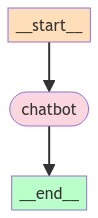

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Testig our Chatbot

In [14]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1])

Assistant: ?
AI: I'm functioning within normal parameters. How may I assist you today?

Human: That's great! I have a few questions about your capabilities. Can you tell me what kind of tasks you're capable of performing?
AI: I'm designed to process and analyze vast amounts of data, generate human-like text, and answer questions to the best of my ability. I can also assist with tasks such as language translation, sentiment analysis, and more.

Human: Wow, that's impressive.
Goodbye!


# Part 2 Intregration of Tools

In this guide we'll build a Chain that does not rely on any special model APIs (like tool calling, which we showed in the Quickstart) and instead just prompts the model directly to invoke tools.

First, we need to create a tool to call. For this example, we will create a custom tool from a function. For more information on all details related to creating custom tools

In [15]:
from langchain_core.tools import tool
@tool
def multiply(first_int: int, second_int: int) -> int:
    """Multiply two integers together."""
    return first_int * second_int

In [16]:
print(multiply.name)
print(multiply.description)
print(multiply.args)

multiply
Multiply two integers together.
{'first_int': {'title': 'First Int', 'type': 'integer'}, 'second_int': {'title': 'Second Int', 'type': 'integer'}}


In [17]:
multiply.invoke({"first_int": 4, "second_int": 5})

20

## Adding an output parser
We'll use the JsonOutputParser for parsing our models output to JSON.

In [18]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain_ibm import WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 100,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)



In [19]:
# Calling multiple prompts

watsonx_llm.generate(
    [
        "The fastest dog in the world?",
        "Describe your chosen dog breed",
    ]
)

LLMResult(generations=[[Generation(text='The fastest dog in the world is the Greyhound. They are able to run up to 45 mph.', generation_info={'finish_reason': 'eos_token'})], [Generation(text='The Boxer is a breed of dog that originated in Germany. They are considered to be one of the most playful and loyal breeds of dogs. They are great with children and other animals. Boxers are very protective of their families and make excellent guard dogs. They are also very intelligent and easy to train. Boxers are known for their wrinkly face and big rectangular head. They have a short coat that is usually white with several different colors. Boxers are a great breed of dog and', generation_info={'finish_reason': 'max_tokens'})]], llm_output={'token_usage': {'generated_token_count': 123, 'input_token_count': 13}, 'model_id': 'ibm/granite-13b-instruct-v2', 'deployment_id': ''}, run=[RunInfo(run_id=UUID('ac28310a-6f74-4993-9a0f-01e4027521fb')), RunInfo(run_id=UUID('9da2557e-037f-47d4-9fe6-33730dc4

Streaming the Model output
You can stream the model output.

In [20]:
for chunk in watsonx_llm.stream(
    "Describe your favorite breed of dog and why it is your favorite."
):
    print(chunk, end="")

My favorite breed of dog is a Labrador Retriever. They are the most loving, loyal, and playful dogs. They are great with kids and other animals. Labs are very smart and easy to train. They are also very active and need a lot of exercise. Labs are the perfect dog for anyone who wants a loving companion. 

Create Chain
Create PromptTemplate objects which will be responsible for creating a random question.

In [21]:
from langchain_core.prompts import PromptTemplate

template = "Generate a random question about {topic}: Question: "
prompt = PromptTemplate.from_template(template)

In [22]:
from langchain.chains import LLMChain

llm_chain = LLMChain(prompt=prompt, llm=watsonx_llm)
llm_chain.invoke("dog")

c:\Dropbox\23-GITHUB\Projects\How-to-build-Multi-Agent-System-with-Langraph\.venv\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


{'topic': 'dog', 'text': 'What is the largest dog breed in the world?'}

In [23]:
from langchain_core.runnables import RunnableSequence

llm_chain = prompt | watsonx_llm
result = llm_chain.invoke("dog")
print(result)

How many legs does a dog have on average?


### Creating our prompt
We'll want to write a prompt that specifies the tools the model has access to, the arguments to those tools, and the desired output format of the model. In this case we'll instruct it to output a JSON blob of the form {"name": "...", "arguments": {...}}.

In [24]:
from langchain.tools.render import render_text_description
rendered_tools = render_text_description([multiply])
rendered_tools

'multiply(first_int: int, second_int: int) -> int - Multiply two integers together.'

In [25]:
from langchain_core.prompts import ChatPromptTemplate
system_prompt = f"""You are an assistant that has access to the following set of tools. 
Here are the names and descriptions for each tool:
{rendered_tools}.
Given the user input, return the name and input of the tool to use. 
Always return your response as a JSON blob with 'name' and 'arguments' keys."""
prompt = ChatPromptTemplate.from_messages(
    [("system", system_prompt), ("user", "{input}")]
)

In [26]:
from langchain_core.runnables import RunnableSequence
llm_chain = prompt | watsonx_llm
result = llm_chain.invoke("what's thirteen times 4")
print(result)

? multiply(13, 4)


In [27]:
result = llm_chain.invoke({"what's thirteen times 4"})
print(result)

{"name": "multiply", "arguments": {"first_int": 13, "second_int": 4}}


In [28]:
def remove_duplicates(elements):
  return list(set(elements))

In [29]:
testing=False
if testing:
    results = []
    for i in range(100):
        result = llm_chain.invoke({"what's thirteen times 4"})
        results.append(result)
        print(f"Iteration {i+1}: {result}")

    print("All results:",results)
    unique_list = remove_duplicates(results)

In [30]:
import json
import re

def process_llm_result(llm_output):
    def extract_numbers(arguments):
        numbers = re.findall(r'\d+', arguments)
        if len(numbers) == 2:
            return {"first_int": int(numbers[0]), "second_int": int(numbers[1])}
        return None

    if isinstance(llm_output, str):
        try:
            llm_output = json.loads(llm_output)
        except json.JSONDecodeError:
            pass

    # Check if it's a valid dictionary with required keys
    if isinstance(llm_output, dict):
        if "name" in llm_output and "arguments" in llm_output:
            if isinstance(llm_output["arguments"], dict):
                if "first_int" in llm_output["arguments"] and "second_int" in llm_output["arguments"]:
                    return llm_output
            elif isinstance(llm_output["arguments"], (list, tuple)) and len(llm_output["arguments"]) == 2:
                try:
                    return {"name": "multiply", "arguments": {"first_int": int(llm_output["arguments"][0]), "second_int": int(llm_output["arguments"][1])}}
                except ValueError:
                    pass

    # List of regex patterns to match and fix the input strings
    patterns = [
        r'{"name":\s*"multiply",\s*"arguments":\s*{"(\d+)":\s*"(\d+)"}}',
        r'name":\s*"multiply",\s*"arguments":\s*{"first_int":\s*(\d+),\s*"second_int":\s*(\d+)}',
        r'name":\s*"multiply",\s*"arguments":\s*{"first_int":\s*(\d+),\s*"second_int":\s*(\d+)}\}',
        r'name:\s*multiply,\s*arguments:\s*{(\d+),\s*(\d+)}',
        r'name:\s*multiply,\s*arguments:\s*\[(\d+),\s*(\d+)\]',
        r'name\[multiply\],\s*arguments\[(\d+),\s*(\d+)\]',
        r'name:\s*multiply,\s*arguments:\s*{first_int:\s*(\d+),\s*second_int:\s*(\d+)}',
        r'name\[multiply\],\s*arguments\[(\d+),(\d+)\]',
        r'\nname:\s*multiply\narguments:\s*{first_int:\s*(\d+),\s*second_int:\s*(\d+)}',
        r'name:\s*multiply\narguments:\s*{first_int:\s*(\d+),\s*second_int:\s*(\d+)}',
        r'name\[JSON blob with \'name\' and \'arguments\' keys\] argument\[(\d+),\s*(\d+)\]',
        r'Human:\s*{"name":\s*"multiply",\s*"arguments":\s*{"first_int":\s*(\d+),\s*"second_int":\s*(\d+)}}',
        r'arguments\{(\d+),\s*(\d+)\}name\[multiply\] arguments\{(\d+),\s*(\d+)\}',
        r',"\s*multiply\((\d+),\s*(\d+)\)',
        r' \{"name":\s*"multiply",\s*"arguments":\s*\["(\d+)",\s*"(\d+)"\]\}',
        r'{"name":\s*"multiply",\s*"arguments":\s*\["(\d+)",\s*"(\d+)"\]}',
        r'name\[istani\],\s*arguments\[(\d+),\s*(\d+)\]',
        r'Response:\s*multiply\((\d+),\s*(\d+)\)',
        r'Response:\s*\{"name":\s*"multiply",\s*"arguments":\s*{\s*"first_int":\s*(\d+),\s*"second_int":\s*(\d+)\s*}\s*\}'
    ]

    if isinstance(llm_output, str):
        for pattern in patterns:
            match = re.search(pattern, llm_output)
            if match:
                numbers = match.groups()
                if len(numbers) == 2:
                    return {"name": "multiply", "arguments": {"first_int": int(numbers[0]), "second_int": int(numbers[1])}}

    return {"name": "multiply", "arguments": {"first_int": "", "second_int": ""}}




In [31]:
llm_output={"name": "multiply", "arguments": {"first_int": 13, "second_int": 4}}

In [34]:
process_llm_result(llm_output)

{'name': 'multiply', 'arguments': {'first_int': 13, 'second_int': 4}}

In [35]:
from langchain_core.output_parsers import JsonOutputParser
llm_chain = prompt | watsonx_llm | JsonOutputParser()
llm_chain.invoke({"what's thirteen times 4"})

{'name': 'multiply', 'arguments': {'first_int': 13, 'second_int': 4}}

In [36]:
llm_chain = prompt | watsonx_llm | process_llm_result
result = llm_chain.invoke("what's thirteen times 4")
print(result)

{'name': 'multiply', 'arguments': {'first_int': '', 'second_int': ''}}


## Invoking the tool
We can invoke the tool as part of the chain by passing along the model-generated "arguments" to it:



In [37]:
from operator import itemgetter

llm_chain = prompt | watsonx_llm |  JsonOutputParser() | process_llm_result | itemgetter("arguments") 
llm_chain.invoke({"what's thirteen times 4"})

{'first_int': 13, 'second_int': 4}

In [38]:
multiply.invoke({"first_int": 4, "second_int": 5})

20

In [41]:
from operator import itemgetter

llm_chain = prompt | watsonx_llm | JsonOutputParser() |process_llm_result | itemgetter("arguments") 
result=llm_chain.invoke({"what's thirteen times 4"})
multiply.invoke(result)



52

In [42]:
from operator import itemgetter

llm_chain = prompt | watsonx_llm | JsonOutputParser() |process_llm_result |  itemgetter("arguments")| multiply
result=llm_chain.invoke({"what's thirteen times 4"})
print(result)


52




## Part 2: Enhancing the Chatbot with Tools
## Web Search Integration
So far, our chatbot can only respond to questions it has been trained on. But what if a user asks a question that our bot doesn't know the answer to? That's where tools come in. We can integrate a web search tool into our chatbot to help it find relevant information and provide better responses.



#### Getting Started

Before we start, make sure you have the necessary packages installed and API keys set up:

1. First, install the requirements to use the [Tavily Search Engine](https://python.langchain.com/docs/integrations/tools/tavily_search/), and set your [TAVILY_API_KEY](https://tavily.com/).

In [62]:
%%capture --no-stderr
%pip install -U tavily-python


2. Set up your TAVILY_API_KEY by running `_set_env("TAVILY_API_KEY")`

In [43]:
import getpass
import os
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")


3. Install the `langchain_community` package using pip: `pip install -U langchain_community`



In [64]:
%%capture --no-stderr
%pip install -U langchain_community

Now, let's create a `TavilySearchResults` tool to help our chatbot search the web for answers:

In [133]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts import PromptTemplate
# Initialize the search tool
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("Who is Ruslan Magana")

[{'url': 'https://ruslanmv.com/about',
  'content': "I'm Ruslan Magana Vsevolodovna. I'm a Data Scientist, a Cloud Architect and a Physicist. About me. I am Data Scientist specializing in Artificial Intelligence, with a distinct focus on Neural Networks. My core expertise lies in Generative AI and prompt engineering. I possess a strong commitment to precision and boast an extensive track ..."},
 {'url': 'https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna',
  'content': 'Nov 2020. Ruslan Magaña Vsevolodovna. The structure of odd-A Rh115,117 and Pd115,117 isotopes is studied by means of the neutron-proton interacting boson-fermion model (IBFM-2). JP=12+ quantum ...'}]

In [134]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain_ibm import WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 100,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)

from langchain_core.prompts import PromptTemplate

template = "Generate a question asking who is the followng person {topic} and repeat the name of the person: Question: "
prompt = PromptTemplate.from_template(template)

llm_chain = prompt | watsonx_llm  | tool 
result = llm_chain.invoke("Ruslan Magana")
print(result)

[{'url': 'https://senatornation.com/news/2024/3/29/general-maga-a-resigns-as-womens-soccer-head-coach.aspx', 'content': 'Story Links. ELKINS, W. Va. - Head women\'s soccer coach, Alberto "Kiko" Magaña, has announced he is resigning from the position, effective immediately. Magaña has spent two seasons at the helm for the D&E women\'s soccer team. He finishes out his tenure with an overall record of 11-22-3 and 9-19-3 in Mountain East Conference play.'}, {'url': 'https://www.gsujaguars.com/sports/wsoc/2023-24/releases/20240401qn4icp', 'content': "Magana had a two-year record with the Senators of 10-22-3 and his 8-9-2 2022 team had five players earn All-Conference team honors. Prior to Davis and Elkins, Magana coaches at Highland Community College in Highland, Kansas, where he was the women's team's first-ever coach."}]


In [63]:
results=[{'url': 'https://scholar.google.com/citations?user=rWBrOpwAAAAJ', 'content': 'Ruslan Magana Vsevolodovna. National Institute for Nuclear Physics. Verified email at ge.infn.it - Homepage. Nuclear Physics Machine Learning Data Science Cloud Computing Big Data. ... R Magana, H Zheng, A Bonasera. International Journal of Modern Physics E 21 (01), 1250006, 2012. 4: 2012:'}, {'url': 'https://ruslanmv.com/', 'content': 'Ruslan Magana Vsevolodovna Artificial Intelligence 🤖, Data Science 📊, Machine Learning 🔢, and Cloud Development ☁️. If you like them, you ended up in the right spot. Blog. Cloud Architecture, Data Science and Machine Learning. About. Hi there, my name is Ruslan Magana Vsevolodovna. ...'}]



In [67]:
results[1]

{'url': 'https://ruslanmv.com/',
 'content': 'Ruslan Magana Vsevolodovna Artificial Intelligence 🤖, Data Science 📊, Machine Learning 🔢, and Cloud Development ☁️. If you like them, you ended up in the right spot. Blog. Cloud Architecture, Data Science and Machine Learning. About. Hi there, my name is Ruslan Magana Vsevolodovna. ...'}

In [104]:
results = [
    {"content": "First result content."},
    {"content": "Second result content."},
    {"content": "Third result content."},
    {"content": "Fourth result content."},
    {"content": "Fifth result content."}
]
def summarize_search_results(results, max_results=4):
  contents = [result["content"] for result in results[:max_results]]
  return " ".join(contents)
summarize_search_results(results)

'First result content. Second result content. Third result content. Fourth result content.'

In [150]:
from typing import List, Dict
from langchain_core.tools import tool
# Define the function and use the @tool decorator
@tool
def summarize_search_results(results: List[Dict[str, str]], max_results: int = 4) -> str:
    """Summarize the contents of the search results.
    Args:
        results (List[Dict[str, str]]): A list of dictionaries containing search results.
        max_results (int): The maximum number of results to include in the summary.
    Returns:
        str: A summary of the contents of the search results.
    """
    contents = [result["content"] for result in results[:max_results]]
    return " ".join(contents)
# Invoke the tool
summary = summarize_search_results.invoke({"results": results, "max_results": 4})
print(summary)

First result content. Second result content. Third result content. Fourth result content.


In [180]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain_ibm import WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from typing import List, Dict
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts import PromptTemplate
# Initialize the search tool
web = TavilySearchResults(max_results=2)
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 100,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)
from langchain_core.prompts import PromptTemplate
template = "Generate a question asking who is the followng person {topic} and repeat the name of the person: Question: "
prompt = PromptTemplate.from_template(template)
llm_chain = prompt | watsonx_llm  | web  
result = llm_chain.invoke("Ruslan Magana")
print(result)

[{'url': 'https://www.armyupress.army.mil/Journals/Military-Review/Online-Exclusive/2016-Online-Exclusive-Articles/Ukraines-Battle-at-Ilovaisk/', 'content': 'As you know, you go to war with the army you have, not the army you might want or wish to have at a later time." - Former U.S. Secretary of Defense Donald Rumsfeld The Army They Had On 28 February 2014, newly-appointed Ukrainian Minister of Defense Ihor Tenyukh briefed the members of Ukraine\'s National Security Council on the state of the armed forces during Russia\'s ongoing annexation ...'}, {'url': 'https://en.wikipedia.org/wiki/List_of_Ministers_of_Defense_(Ukraine)', 'content': 'The minister of defence of Ukraine (Ukrainian: ... 27 February 2014: 1 year, 65 days: Party of Regions ... 18 August 2010 - 18 February 2012 Volodymyr Mozharovskyi; 18 February 2012 - 5 March 2014 Oleksandr Oliynyk; 15 September 2014 - 14 February 2023 Ivan Rusnak;'}]


In [195]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain_ibm import WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from typing import List, Dict
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts import PromptTemplate

# Initialize the search tool
web = TavilySearchResults(max_results=2)

# Define the function and use the @tool decorator
@tool
def summarize_search_results(results: List[Dict[str, str]], max_results: int = 4) -> str:
    """Summarize the contents of the search results.
    Args:
        results (List[Dict[str, str]]): A list of dictionaries containing search results.
        max_results (int): The maximum number of results to include in the summary.
    Returns:
        str: A summary of the contents of the search results.
    """
    contents = [result["content"] for result in results[:max_results]]
    return " ".join(contents)

# Set up parameters and model for WatsonxLLM
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 100,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)

# Define prompt template
template = "Generate a question asking who is the following person {topic} and repeat the name of the person: Question: "
prompt = PromptTemplate.from_template(template)

# Define the chain without the summarize_search_results yet
llm_chain = prompt | watsonx_llm | web

# Invoke the chain to get results
results = llm_chain.invoke("Ruslan Magana")

# Now, invoke the summarize_search_results with the correct input
summary = summarize_search_results.invoke({"results": results})

# Print the summary
print(summary)


I am an enthusiastic and motivated scientific professional in IT occupational sector. I am Specialised in physical sciences, particularly in massive computa... About me. I am Data Scientist specializing in Artificial Intelligence, with a distinct focus on Neural Networks. My core expertise lies in Generative AI and prompt engineering. I possess a strong commitment to precision and boast an extensive track record across diverse domains, including Data Extraction, Statistical Modeling, Data Mining ...


In [197]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain_ibm import WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from typing import List, Dict
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts import PromptTemplate

# Initialize the search tool
web = TavilySearchResults(max_results=2)

# Define the function and use the @tool decorator
@tool
def summarize_search_results(results: List[Dict[str, str]], max_results: int = 4) -> str:
    """Summarize the contents of the search results.
    Args:
        results (List[Dict[str, str]]): A list of dictionaries containing search results.
        max_results (int): The maximum number of results to include in the summary.
    Returns:
        str: A summary of the contents of the search results.
    """
    contents = [result["content"] for result in results[:max_results]]
    return " ".join(contents)

# Set up parameters and model for WatsonxLLM
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 100,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)

# Define prompt template
template = "Generate a question asking who is the following person {topic} and repeat the name of the person: Question: "
prompt = PromptTemplate.from_template(template)

# Define the chain without the summarize_search_results yet
llm_chain = prompt | watsonx_llm | web
person="Ruslan Magana"
# Invoke the chain to get results
results = llm_chain.invoke(person)

# Now, invoke the summarize_search_results with the correct input
summary = summarize_search_results.invoke({"results": results})

print(summary)


About me. I am Data Scientist specializing in Artificial Intelligence, with a distinct focus on Neural Networks. My core expertise lies in Generative AI and prompt engineering. I possess a strong commitment to precision and boast an extensive track record across diverse domains, including Data Extraction, Statistical Modeling, Data Mining ... Ruslan Magana Vsevolodovna. Machine Learning Engineer & Data Scientist & Physicist Follow. Genoa, Italy; Email Keybase Twitter ... I have proposed a function in terms of energy and with my team, we expanded the energy per particle (E/A) of symmetric infinite nuclear matter in powers of the density to take into account 2, 3, . . . , N-body ...


In [223]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain_ibm import WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from typing import List, Dict
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts import PromptTemplate

# Initialize the search tool
web = TavilySearchResults(max_results=2)

# Define the function and use the @tool decorator

def summarize_search_results(results: List[Dict[str, str]], max_results: int = 4) -> str:
    """Summarize the contents of the search results.
    Args:
        results (List[Dict[str, str]]): A list of dictionaries containing search results.
        max_results (int): The maximum number of results to include in the summary.
    Returns:
        str: A summary of the contents of the search results.
    """
    contents = [result["content"] for result in results[:max_results]]
    return " ".join(contents)

# Set up parameters and model for WatsonxLLM
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 100,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)

# Define prompt template
template1= "Generate a question asking who is the following person {topic} and repeat the name of the person: Question: "
prompt1 = PromptTemplate.from_template(template1)
# Define the llm_chain including summarize_search_results
llm_chain1 = prompt1 | watsonx_llm | web | summarize_search_results
# Now, invoke the llm_chain as before
person="Ruslan Magana"
websearch = llm_chain1.invoke(person)
# Print the result
print(websearch)






I'm Ruslan Magana Vsevolodovna. I'm a Data Scientist, a Cloud Architect and a Physicist. About me. I am Data Scientist specializing in Artificial Intelligence, with a distinct focus on Neural Networks. My core expertise lies in Generative AI and prompt engineering. I possess a strong commitment to precision and boast an extensive track ... Ruslan Magana Vsevolodovna. National Institute for Nuclear Physics. Verified email at ge.infn.it - Homepage. Nuclear Physics Machine Learning Data Science Cloud Computing Big Data. ... R Magana, H Zheng, A Bonasera. International Journal of Modern Physics E 21 (01), 1250006, 2012. 4: 2012:


In [267]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain_ibm import WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from typing import List, Dict
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts import PromptTemplate

# Initialize the search tool
web = TavilySearchResults(max_results=2)
# Define the function and use the @tool decorator
def summarize_search_results(results: List[Dict[str, str]], max_results: int = 4) -> str:
    """Summarize the contents of the search results.
    Args:
        results (List[Dict[str, str]]): A list of dictionaries containing search results.
        max_results (int): The maximum number of results to include in the summary.
    Returns:
        str: A summary of the contents of the search results.
    """
    contents = [result["content"] for result in results[:max_results]]
    return " ".join(contents)
# Set up parameters and model for WatsonxLLM
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 100,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)
#Chain 1
# Define the llm_chain including summarize_search_results
llm_chain1 =  web | summarize_search_results
# Now, invoke the llm_chain as before
person="Ruslan Magana"
websearch = llm_chain1.invoke(person)
# Print the result
#print("Websearch results :\n", websearch)
# Define prompt template 2
template2 = "You are an assistant websearch. Based on the following websearch: {websearch}.  who is this person {person} and describe. Answer:"
prompt2 = PromptTemplate.from_template(template2)
#Chain 2
# Define llm_chain2 including websearch result and the second template
llm_chain2 = prompt2 | watsonx_llm

# Now, invoke llm_chain2
person = "Ruslan Magana"
result = llm_chain2.invoke({"websearch": websearch, "person": person})

# Print the result
print("Answer:\n", result)



Answer:
 Ruslan Magana Vsevolodovna, PhD. is an expert in Artificial Intelligence with a focus on Neural Networks. His primary expertise lies in Generative AI and prompt engineering, with experience in the field of watsonx.ai. In his role, he is involved in researching, building, and designing artificial intelligence systems, specifically for Natural Language Processing tasks. He has a PhD in Nuclear Physics from the National Institute for Nuclear Physics. He is the author of the book "


In [326]:
from googlesearch import search

python_query = "Python"
for result in search(python_query):
  print(result)

# This will print each search result (URL) one by one

https://www.python.org/
https://www.python.org/
https://en.wikipedia.org/wiki/Python_(programming_language)
https://www.w3schools.com/python/
https://it.wikipedia.org/wiki/Python
https://www.w3schools.com/python/python_intro.asp
https://github.com/python/cpython
https://www.codecademy.com/catalog/language/python
https://marketplace.visualstudio.com/items?itemName=ms-python.python
https://realpython.com/


In [330]:
from googlesearch import search
import requests
from bs4 import BeautifulSoup

# Define the query
python_query = "Ruslan Magana"

# Search for the query and fetch URLs
for url in search(python_query, num_results=10):
    print("URL:", url)
    try:
        # Fetch the content of the URL
        response = requests.get(url, timeout=5)
        response.raise_for_status()  # Check if the request was successful
        content = response.content

        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(content, 'html.parser')

        # Extract the description meta tag
        description = None
        if soup.find("meta", attrs={"name": "description"}):
            description = soup.find("meta", attrs={"name": "description"}).get("content")
        elif soup.find("meta", attrs={"property": "og:description"}):
            description = soup.find("meta", attrs={"property": "og:description"}).get("content")

        # Print the description if found
        if description:
            print("Description:", description)
        else:
            print("Description: Not found")

    except requests.exceptions.RequestException as e:
        print("Failed to fetch URL:", url)
        print("Error:", e)

    print()  # Print a newline for better readability


URL: https://it.linkedin.com/in/ruslanmv
Description: Not found

URL: https://ruslanmv.com/
Description: We talk about Machine Learning, Generative AI, Data Science and Cloud Development

URL: https://scholar.google.com/citations?user=rWBrOpwAAAAJ&hl=it
Failed to fetch URL: https://scholar.google.com/citations?user=rWBrOpwAAAAJ&hl=it
Error: 429 Client Error: Too Many Requests for url: https://scholar.google.com/citations?user=rWBrOpwAAAAJ&hl=it

URL: https://github.com/ruslanmv
Description: I am Data Scientist and Data Engineer. I have a Ph.D. in Physics  and I am AWS certified in Machine Learning and Data Analytics - ruslanmv

URL: https://ruslanmv.com/about
Description: Hi there! My name Ruslan Magana Vsevolodovna

URL: https://www.youtube.com/c/ruslanmv/playlists
Description: I am an enthusiastic and motivated scientific professional  in IT occupational sector. I am Specialised in physical sciences, particularly in massive computa...

URL: https://www.researchgate.net/profile/Ruslan

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Description: Not found



In [328]:
from googlesearch import search
import requests
from bs4 import BeautifulSoup

python_query = "Ruslan Magana"
results = search(python_query, num_results=10)

for url in results:
    try:
        # Fetch webpage content
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        response.raise_for_status()  # Ensure we notice bad responses
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find meta description
        meta_description = soup.find('meta', attrs={'name': 'description'})
        description_content = meta_description['content'].strip() if meta_description else 'No description available.'

        # Find the first paragraph or relevant section
        first_paragraph = soup.find('p')
        first_sentence = first_paragraph.text.strip()[:500] if first_paragraph else 'No paragraph available.'
        print(f"URL: {url}\nDescription: {description_content}\nFirst Paragraph: {first_sentence}\n")

    except requests.RequestException as e:
        print(f"Failed to retrieve {url}: {e}")
    except Exception as e:
        print(f"An error occurred while processing {url}: {e}")


URL: https://it.linkedin.com/in/ruslanmv
Description: I am an expert in Artificial Intelligence with a focus on Neural Networks. My primary… · Esperienza: IBM · Formazione: Università degli Studi di Genova · Località: Milano · 266 collegamenti su LinkedIn. Vedi il profilo di Ruslan Magana Vsevolodovna, PhD su LinkedIn, una community professionale di 1 miliardo di utenti.
First Paragraph: LinkedIn e terze parti utilizzano cookie essenziali e non essenziali per fornire, rendere sicuri, analizzare e migliorare i nostri servizi e per mostrarti annunci pertinenti (inclusi annunci professionali e offerte di lavoro) su LinkedIn e altrove. Per saperne di più, consulta la nostra Informativa sui cookie.

URL: https://ruslanmv.com/
Description: We talk about Machine Learning, Generative AI, Data Science and Cloud Development
First Paragraph: 

URL: https://scholar.google.com/citations?user=rWBrOpwAAAAJ&hl=it
Description: ‪National Institute for Nuclear Physics‬ - ‪‪445 citazioni‬‬ - ‪Nuclear Phys

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


URL: https://cloud-data-science.com/wp-content/uploads/2021/03/RuslanCV.pdf
Description: No description available.
First Paragraph: No paragraph available.



In [335]:
from googlesearch import search
import requests
from bs4 import BeautifulSoup

def websearch(query, num_results=10):
    # Initialize an empty string to accumulate all descriptions
    all_descriptions = ""
    results_data = []

    # Perform the search
    results = search(query, num_results=num_results)

    for url in results:
        try:
            # Fetch webpage content
            response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
            response.raise_for_status()  # Ensure we notice bad responses
            soup = BeautifulSoup(response.content, 'html.parser')

            # Find meta description
            meta_description = soup.find('meta', attrs={'name': 'description'})
            description_content = meta_description['content'].strip() if meta_description else 'No description available.'

            # Find the first paragraph or relevant section
            first_paragraph = soup.find('p')
            first_sentence = first_paragraph.text.strip()[:500] if first_paragraph else 'No paragraph available.'

            # Append the description to the all_descriptions string
            all_descriptions += description_content + "\n"

            # Store the result data
            results_data.append({
                'url': url,
                'description': description_content,
                'first_paragraph': first_sentence
            })

        except requests.RequestException as e:
            print(f"Failed to retrieve {url}: {e}")
        except Exception as e:
            print(f"An error occurred while processing {url}: {e}")

    # Print individual results
    for data in results_data:
        print(f"URL: {data['url']}\nDescription: {data['description']}\nFirst Paragraph: {data['first_paragraph']}\n")

    # Print the combined descriptions
    print("\nAll Descriptions Combined:\n")
    print(all_descriptions)
    return all_descriptions

# Example usage:
python_query = "Ruslan Magana"
result_websearch=websearch(python_query)


Failed to retrieve https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna: 403 Client Error: Forbidden for url: https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna
URL: https://it.linkedin.com/in/ruslanmv
Description: I am an expert in Artificial Intelligence with a focus on Neural Networks. My primary… · Esperienza: IBM · Formazione: Università degli Studi di Genova · Località: Milano · 266 collegamenti su LinkedIn. Vedi il profilo di Ruslan Magana Vsevolodovna, PhD su LinkedIn, una community professionale di 1 miliardo di utenti.
First Paragraph: LinkedIn e terze parti utilizzano cookie essenziali e non essenziali per fornire, rendere sicuri, analizzare e migliorare i nostri servizi e per mostrarti annunci pertinenti (inclusi annunci professionali e offerte di lavoro) su LinkedIn e altrove. Per saperne di più, consulta la nostra Informativa sui cookie.

URL: https://ruslanmv.com/
Description: We talk about Machine Learning, Generative AI, Data Science and Cloud D

In [2]:
%%capture --no-stderr
%pip install -U googlesearch-python==1.2.4

In [1]:
from googlesearch import search

In [3]:
help(search)

Help on function search in module googlesearch:

search(term, num_results=10, lang='en', proxy=None, advanced=False, sleep_interval=0, timeout=5, safe='active', ssl_verify=None)
    Search the Google search engine



In [5]:
from googlesearch import search
import requests
from bs4 import BeautifulSoup
from langchain_core.tools import tool

@tool
def websearch(query, num_results=10):
    """
    Perform a web search for the given query, retrieve descriptions and first paragraphs
    from the results, and print them in a readable format. Also, append all descriptions
    into a single string and print it.

    Args:
        query (str): The search query.
        num_results (int): The number of search results to retrieve. Default is 10.

    Returns:
        None
    """
    # Initialize an empty string to accumulate all descriptions
    all_descriptions = ""
    results_data = []

    # Perform the search
    results = search(query, num_results=num_results)

    for url in results:
        try:
            # Fetch webpage content
            response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
            response.raise_for_status()  # Ensure we notice bad responses
            soup = BeautifulSoup(response.content, 'html.parser')

            # Find meta description
            meta_description = soup.find('meta', attrs={'name': 'description'})
            description_content = meta_description['content'].strip() if meta_description else 'No description available.'

            # Find the first paragraph or relevant section
            first_paragraph = soup.find('p')
            first_sentence = first_paragraph.text.strip()[:500] if first_paragraph else 'No paragraph available.'

            # Append the description to the all_descriptions string
            all_descriptions += description_content + "\n"

            # Store the result data
            results_data.append({
                'url': url,
                'description': description_content,
                #'first_paragraph': first_sentence
            })

        except requests.RequestException as e:
            print(f"Failed to retrieve {url}: {e}")
        except Exception as e:
            print(f"An error occurred while processing {url}: {e}")

    # Print individual results
   # for data in results_data:
   #     print(f"URL: {data['url']}\n Description: {data['description']}\n ")#First Paragraph: {data['first_paragraph']}\n

    # Print the combined descriptions
   # print("\nAll Descriptions Combined:\n")
   # print(all_descriptions)
    return all_descriptions

# Example usage:
python_query = "Ruslan Magana"
websearch.invoke(python_query)


Failed to retrieve https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna: 403 Client Error: Forbidden for url: https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


'I am an expert in Artificial Intelligence with a focus on Neural Networks. My primary… · Esperienza: IBM · Formazione: Università degli Studi di Genova · Località: Milano · 266 collegamenti su LinkedIn. Vedi il profilo di Ruslan Magana Vsevolodovna, PhD su LinkedIn, una community professionale di 1 miliardo di utenti.\nWe talk about Machine Learning, Generative AI, Data Science and Cloud Development\n\u202aNational Institute for Nuclear Physics\u202c - \u202a\u202a445 citazioni\u202c\u202c - \u202aNuclear Physics\u202c - \u202aMachine Learning\u202c - \u202aData Science\u202c - \u202aCloud Computing\u202c - \u202aBig Data\u202c\nI am Data Scientist and Data Engineer. I have a Ph.D. in Physics  and I am AWS certified in Machine Learning and Data Analytics - ruslanmv\nNo description available.\nHi there! My name Ruslan Magana Vsevolodovna\nNo description available.\nI’m happy to share that I’ve obtained a new certification: watsonx.data Technical Sales Intermediate from IBM!\nNo descrip

In [6]:



import os
from dotenv import load_dotenv
import getpass
def _set_env(var: str):
    load_dotenv()  # Load environment variables from .env file
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

api_key = _set_env("WATSONX_API_KEY")
project_id = _set_env("PROJECT_ID")
url = "https://us-south.ml.cloud.ibm.com"






In [8]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain_ibm import WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from typing import List, Dict
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 100,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)

template = "Answer this question {question}  based on the following websearch: {result_websearch}. Answer:"
prompt = PromptTemplate.from_template(template)
llm_chain = websearch # | prompt | watsonx_llm
# Now, invoke llm_chain
question = "Who is Ruslan Magana"
result = llm_chain.invoke(question)
# Print the result
print("Answer:\n", result)



Failed to retrieve https://it.linkedin.com/in/ruslanmv: 429 Client Error: Request denied for url: https://it.linkedin.com/in/ruslanmv
Failed to retrieve https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna: 403 Client Error: Forbidden for url: https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Answer:
 We talk about Machine Learning, Generative AI, Data Science and Cloud Development
About Ruslan Magana Vsevolodovna on Medium. Machine Learning Engineer & Data Scientist & Physicist.
I am Data Scientist and Data Engineer. I have a Ph.D. in Physics  and I am AWS certified in Machine Learning and Data Analytics - ruslanmv
Play Ruslan Magana Vsevolodovna and discover followers on SoundCloud | Stream tracks, albums, playlists on desktop and mobile.
I’m happy to share that I’ve obtained a new certification: watsonx.data Technical Sales Intermediate from IBM!
Read writing from Ruslan Magana Vsevolodovna on Medium. Machine Learning Engineer & Data Scientist & Physicist. Every day, Ruslan Magana Vsevolodovna and thousands of other voices read, write, and share important stories on Medium.
No description available.
No description available.
No description available.



In [364]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain_ibm import WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from typing import List, Dict
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate

# WatsonxLLM parameters and model initialization
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 100,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)
# Prompt template
template = "Answer this question {question} based on the following websearch: {result_websearch}. Answer:"
prompt = PromptTemplate.from_template(template)
# Function to create the chain
def create_chain(question):
    # Get the websearch results
    result_websearch = websearch.invoke(question)
    # Create the prompt with the websearch results
    formatted_prompt = prompt.format(question=question, result_websearch=result_websearch)
    print(formatted_prompt)
    # Get the answer from the LLM
    answer = watsonx_llm(formatted_prompt)
    return answer
# Example usage:
question = "Who is Ruslan Magana"
result = create_chain(question)
print("Answer:\n", result)


Answer this question Who is Ruslan Magana based on the following websearch: I am an expert in Artificial Intelligence with a focus on Neural Networks. My primary… · Esperienza: IBM · Formazione: Università degli Studi di Genova · Località: Milano · 266 collegamenti su LinkedIn. Vedi il profilo di Ruslan Magana Vsevolodovna, PhD su LinkedIn, una community professionale di 1 miliardo di utenti.
We talk about Machine Learning, Generative AI, Data Science and Cloud Development
About Ruslan Magana Vsevolodovna on Medium. Machine Learning Engineer & Data Scientist & Physicist.
I am Data Scientist and Data Engineer. I have a Ph.D. in Physics  and I am AWS certified in Machine Learning and Data Analytics - ruslanmv
Play Ruslan Magana Vsevolodovna and discover followers on SoundCloud | Stream tracks, albums, playlists on desktop and mobile.
I’m happy to share that I’ve obtained a new certification: watsonx.data Technical Sales Intermediate from IBM!
Ruslan MAGAÑA VSEVOLODOVNA, PhD | Cited by 37

In [12]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain_ibm import WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
from langchain.prompts import PromptTemplate
# WatsonxLLM parameters and model initialization
parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 500,
    GenParams.MIN_NEW_TOKENS: 50, # Ensure a minimum length for responses
    GenParams.TEMPERATURE: 0.7, # Lower temperature for more focused output
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}
model_id = "ibm/granite-13b-instruct-v2"
watsonx_llm = WatsonxLLM(
    model_id=model_id,
    url=url,
    apikey=api_key,
    project_id=project_id,
    params=parameters
)
# Prompt template
template = "You are a chatbot you should answer this question {question} and summarize the following websearch results: {result_websearch}. Answer:"
prompt = PromptTemplate.from_template(template)
# Define the chain using LangChain syntax with a fix
chain = websearch | (lambda result: prompt.format(question=question, result_websearch=result)) | watsonx_llm
# Example usage with LangChain chain
question = "Who is Ruslan Magana"
result = chain.invoke(question)
print("Answer:\n", result)

Failed to retrieve https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna: 403 Client Error: Forbidden for url: https://www.researchgate.net/profile/Ruslan-Magana-Vsevolodovna


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Answer:
 Ruslan Magana Vsevolodovna is a Data Scientist and Data Engineer. He has a Ph.D. in Physics and he is AWS certified in Machine Learning and Data Analytics. Ruslan Magana Vsevolodovna is happy to share that he has obtained a new certification: Watsonx.Data Technical Sales Intermediate from IBM!


In [14]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [15]:
def chatbot(query):
    return {"messages": [chain.invoke(query)]}
graph_builder.add_node("chatbot", chatbot)


```

```
This code sets up a `TavilySearchResults` tool that can search the web for answers to user questions. We'll use this tool to enhance our chatbot's abilities in the next section.

In [372]:
#def chatbot(state: State):
#    return {"messages": [chain.invoke(state["messages"])]}
#graph_builder.add_node("chatbot", chatbot)

In [17]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


#tool_node = BasicToolNode(tools=[tool])

tool_node = BasicToolNode(tools=[websearch])
graph_builder.add_node("tools", tool_node)

In [18]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """Use in the conditional_edge to route to the ToolNode if the last message

    has tool calls. Otherwise, route to the end."""
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

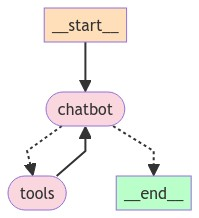

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [20]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1])

ValidationError: 1 validation error for websearchSchema
query
  field required (type=value_error.missing)